# Data Exploration Project - Datenset Valentinstag

### Beschreibung des Datensets

Der Datensatz ``Valentine's Day Consumer Data`` besteht aus drei csv-Dateien, die Verbraucherverhalten und Ausgabegewohnheiten zum Valentinstag in den USA über ein Jahrzehnt hinweg abbilden. Die Daten stammen von der National Retail Federation (NRF) und umfassen 12 Jahre. Die Dateien bieten Einblicke in:

- ``gifts_age.csv``: Präferenz von Geschenkarten nach Altersgruppen in Prozent.
- ``gifts_gender.csv``: Prozentsatz von Männern und Frauen, die solche Geschenke kaufen.
- ``historical_spending.csv``: Preisentwicklung von 2010-2022, inklusive Durchschnittspreis pro Geschenk und Ausgaben pro Person.

Das Projekt wurde aufgrund der aktuellen Relevanz und dem Interesse am Verlauf des Verbraucherverhaltens zum Valentinstag ausgewählt. Anhand dieser Erkenntnisse leitet sich die Projektidee ab, in der mithilfe einer Modell Vorhersage über die mögliche Preisentwicklung, gezielte Marketingstrategien ergriffen und angestrebt werden können. Dieses wird mit mit der Suche nach dem bestmöglichen Classifier für den gezielten Fall angegangen. 

#### FYI:
 Zu Beginn wurde der Klassifikationsansatz verfolgt, eine Vorhersage zu treffen, ob ein bestimmtes Produkt von einer Frau oder einem Mann gekauft und verschenkt wurde. Dieser Ansatz wurde jedoch verworfen, da die Daten der ``gifts_gender.csv`` als Prozentangaben übergeben werden und die Informationen über die ANzahl der befragten Personen fehlt, um diese Werte in absolute Zahlen zu berechnen. 

Die benötigten Bibliotheken werden installiert und in der req.txt abgespeichert.

In [1]:
! pip install -r req.txt

In [2]:
import pandas as pd
import plotly.subplots as sp
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as pltimport 
import joblib
import datetime
import json
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor


/var/folders/cg/mg68t49x6cd4x_34ppt4f9fr0000gn/T/ipykernel_73283/499071930.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Charakterisierung des Datensets

In dieser Analyse wird untersucht, wie sich die Geschenkausgaben für verschiedene Geschenkkategorien zwischen den Geschlechtern verteilen. Die Balkendiagramme visualisieren den prozentualen Anteil der Ausgaben für jede Kategorie, unterteilt nach Geschlecht. Das Verständnis der geschlechtsspezifischen Unterschiede bei den Geschenkausgaben kann Händlern dabei helfen, ihre Marketingstrategien zu optimieren und gezielte Werbekampagnen zu entwickeln, die auf die bestimmten Zielgruppen abzielen.

In [3]:
#Stacked Bar Chart

df = pd.read_csv('gifts_gender.csv')
df_percent = df.set_index('Gender').div(df.set_index('Gender').sum(axis=1), axis=0) * 100

fig = go.Figure()

for column in df_percent.columns:
    fig.add_trace(go.Bar(x=df_percent.index, y=df_percent[column], name=column))

fig.update_layout(
    barmode='stack',
    xaxis=dict(title='Gender'),
    yaxis=dict(title='Percentage'),
    title='Percentage of different gifts by gender'
)

fig.show()

print(df.head())


  Gender  SpendingCelebrating  Candy  Flowers  Jewelry  GreetingCards  \
0    Men                   27     52       56       30             37   
1  Women                   27     59       19       14             43   

   EveningOut  Clothing  GiftCards  
0          33        20         18  
1          29        24         24  


Hier wird analysiert, wie sich die Geschenkausgaben für verschiedene Altersgruppen verteilen. Die Pie-Charts zeigen den prozentualen Anteil der Ausgaben für jede Kategorie in verschiedenen Altersgruppen. Die Kenntnis der altersspezifischen Ausgabegewohnheiten kann Unternehmen dabei unterstützen, Produkte und Angebote zu entwickeln, die besser auf die Bedürfnisse und Vorlieben verschiedener Altersgruppen abgestimmt sind.

In [4]:
#pie chart

df = pd.read_csv('gifts_age.csv')
df = df.drop(columns=['SpendingCelebrating'])

fig = sp.make_subplots(rows=2, cols=3, subplot_titles=df['Age'].tolist(), specs=[[{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}],
                                                                                   [{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}]])

for i, age_group in enumerate(df['Age']):
    percentages = df[df['Age'] == age_group].squeeze()[1:]
    fig.add_trace(go.Pie(labels=percentages.index, values=percentages, hole=0.3, name=age_group),
                  row=(i // 3) + 1, col=(i % 3) + 1)

fig.update_layout(title_text='Percentage of gifts by age group', showlegend=False)

fig.show()

In [ ]:
df = pd.read_csv('historical_spending.csv')

Das Liniendiagramm zeigt den zeitlichen Verlauf der Valentinstagsausgaben. Es visualisiert Trends und Veränderungen im Ausgabeverhalten und bei der Feierquote über die Jahre. Durch die Darstellung verschiedener Ausgabenkategorien wird deutlich, welche Geschenke an Beliebtheit gewonnen oder verloren haben. Durch Klicken auf die Legendenlinien können diese im Diagramm ein- oder ausgeblendet werden. 

*Beachtung der Achsenbeschriftung auf beiden Seiten!*

In [6]:
#line diagram

fig = go.Figure()

categories = df.columns[2:]
for category in categories:
    fig.add_trace(go.Scatter(x=df['Year'], y=df[category], mode='lines', name=category))

fig.add_trace(go.Scatter(x=df['Year'], y=df['PercentCelebrating'], mode='lines', name='PercentCelebrating', yaxis='y2'))

fig.update_layout(title_text='Historical course of spending behaviour (2010-2022)',
                  xaxis_title='Jahr', yaxis_title='Percentage/expenditure in US dollars',
                  yaxis2=dict(title='Percentage of those celebrating', overlaying='y', side='right', range=[0, 100]),
                  legend=dict(font=dict(size=10), orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))


fig.show()

Eine gründliche Analyse der Datenqualität ist entscheidend, um sicherzustellen, dass die Ergebnisse zuverlässig und aussagekräftig sind. Dies hilft auch dabei, potenzielle Probleme oder Lücken im Datensatz zu identifizieren, die die Interpretation der Ergebnisse beeinträchtigen könnten. Die Datenqualität dieses Datensatzes wurde durch mehrere Analysen bewertet, einschließlich der Überprüfung auf fehlende Werte und der Erstellung einer Korrelationsmatrix. Im Valentinstagsdatensatz sind keine Null-Werte vorhanden, was auf eine sehr gute Datenqualität schließen lässt. Zudem sind alle Werte konsequent im gleichen Format dargestellt, was ihre Interpretation erleichtert. Die Korrelationsmatrix offenbart, dass die Ausgaben für Candy, Flowers, Jewelry sowie Clothing und GiftCards stark miteinander korrelieren. Daraus lässt sich schließen, dass diese Geschenkartikel häufig gemeinsam erworben und verschenkt werden. 
Die Datenqualität der anderen Datensets ist recht gut, da dort ebenfalls keine Null-Werte vorhanden sind, die angegebenen Werte jedoch in Prozent angegeben sind und nicht als absolute Werte, wodurch die Gesamtbewertung etwas schwieriger zu treffen ist.

                  Candy   Flowers   Jewelry  GreetingCards  EveningOut  \
Candy          1.000000  0.872253  0.816683       0.539737    0.403856   
Flowers        0.872253  1.000000  0.886656       0.438297    0.488140   
Jewelry        0.816683  0.886656  1.000000       0.398171    0.651477   
GreetingCards  0.539737  0.438297  0.398171       1.000000    0.328747   
EveningOut     0.403856  0.488140  0.651477       0.328747    1.000000   
Clothing       0.929729  0.868605  0.761607       0.463964    0.298995   
GiftCards      0.832338  0.703213  0.719936       0.492484    0.264857   

               Clothing  GiftCards  
Candy          0.929729   0.832338  
Flowers        0.868605   0.703213  
Jewelry        0.761607   0.719936  
GreetingCards  0.463964   0.492484  
EveningOut     0.298995   0.264857  
Clothing       1.000000   0.911497  
GiftCards      0.911497   1.000000  


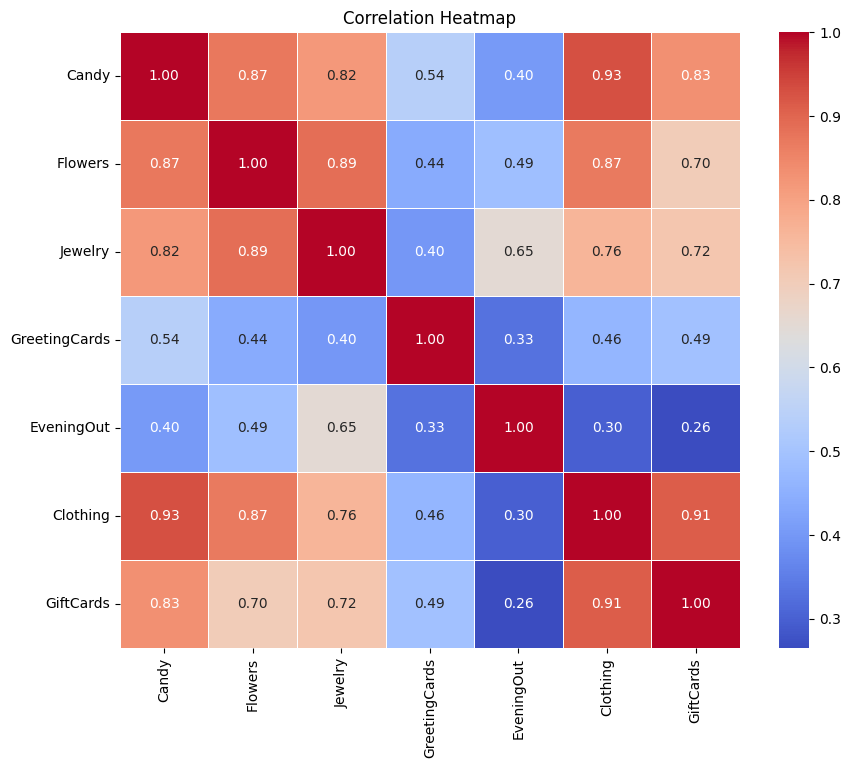

In [38]:
#Correlationmatrix/-heatmap

df.drop(['Year', 'PerPerson', 'PercentCelebrating'], axis=1, inplace=True)

correlation_matrix = df.corr()

print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [8]:
#Verification of data quality

missing_values = df.isnull().sum()

print("Missing values per column:")
print(missing_values)

Missing values per column:
Candy            0
Flowers          0
Jewelry          0
GreetingCards    0
EveningOut       0
Clothing         0
GiftCards        0
dtype: int64


Die Histogrammanalyse bietet Einblicke in die Ausgabenverteilung für verschiedene Produkte im Datensatz. Auf der X-Achse sind die jeweiligen Datenkategorien und auf der Y-Achse die Häufigkeit der Werte dargestellt. Die Daten sind um einen Mittelwert zentriert und gleichmäßig verteilt, was auf eine ausgewogene Datenverteilung hinweist. Es gibt keine klare Tendenz zur Erhöhung oder Senkung der Durchschnittswerte.

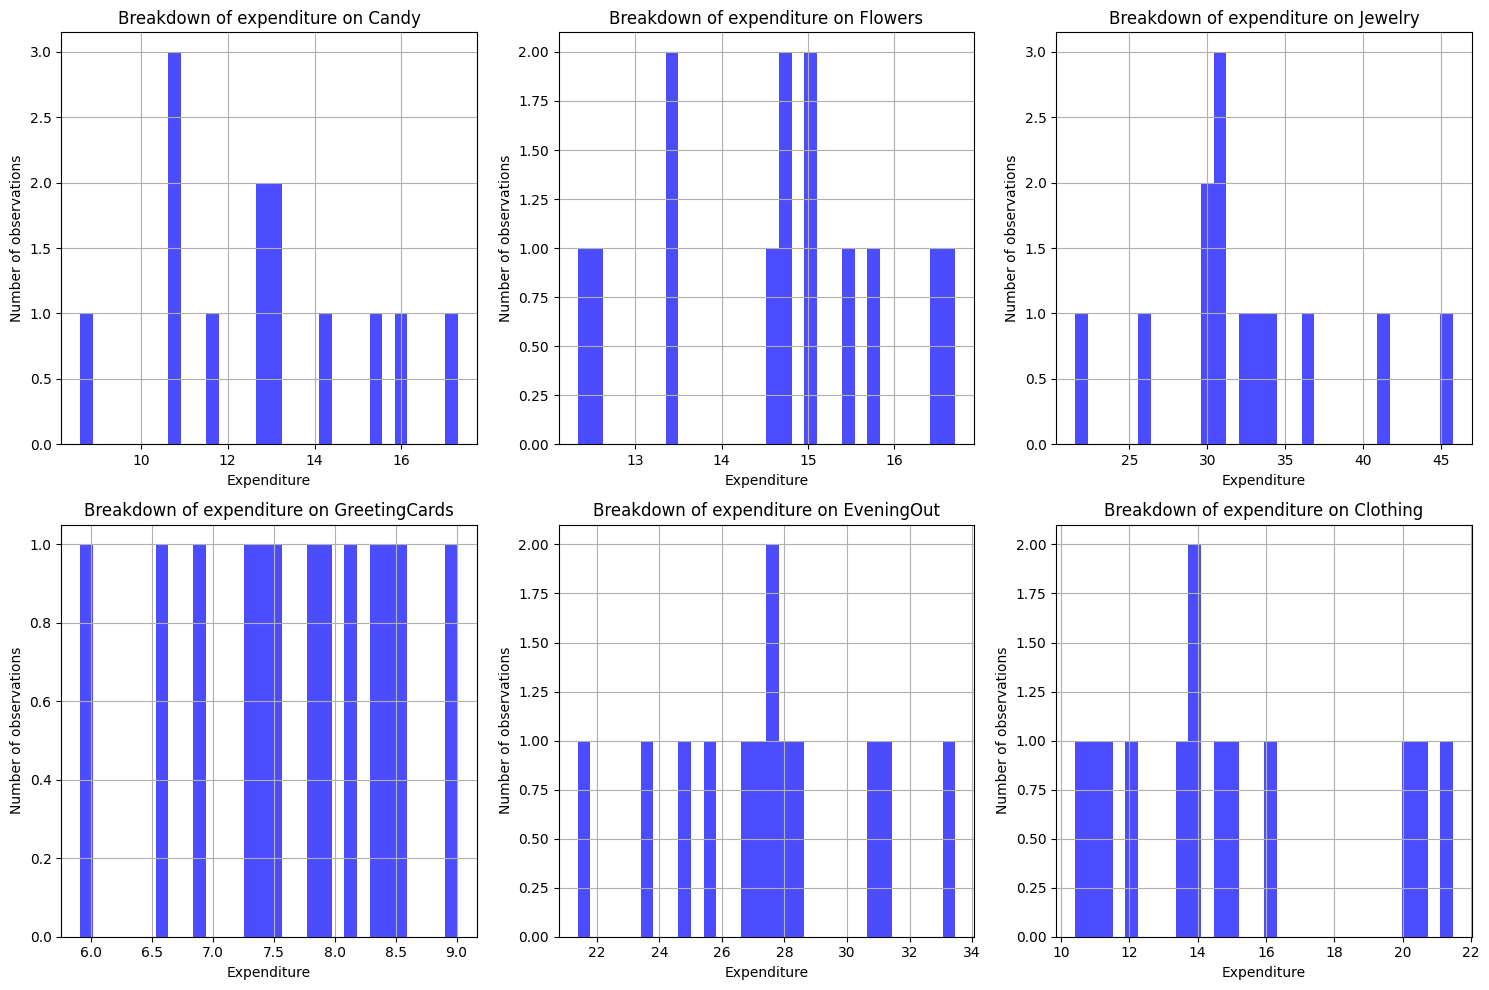

In [39]:
#Balancing of the data set

df = pd.read_csv('historical_spending.csv')
# Liste der relevanten Spalten (außer 'Year')
categories = df.columns[3:-1]

num_plots = len(categories)
num_cols = 3 
num_rows = -(-num_plots // num_cols) 

plt.figure(figsize=(15, 5 * num_rows))

#create subplots 
for i, category in enumerate(categories, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.hist(df[category], bins=30, color='blue', alpha=0.7)
    plt.title(f'Breakdown of expenditure on {category}')
    plt.xlabel('Expenditure')
    plt.ylabel('Number of observations')
    plt.grid(True)

plt.tight_layout()
plt.show()


In [10]:
df = pd.read_csv('historical_spending.csv')

Der Boxplot dient der Erkennung potenzieller Ausreißer in den Daten. Es wurden keine signifikanten Ausreißer identifiziert. Die Ausgaben für Jewelry sind leicht höher als bei anderen Kategorien, jedoch nicht signifikant unterschiedlich.

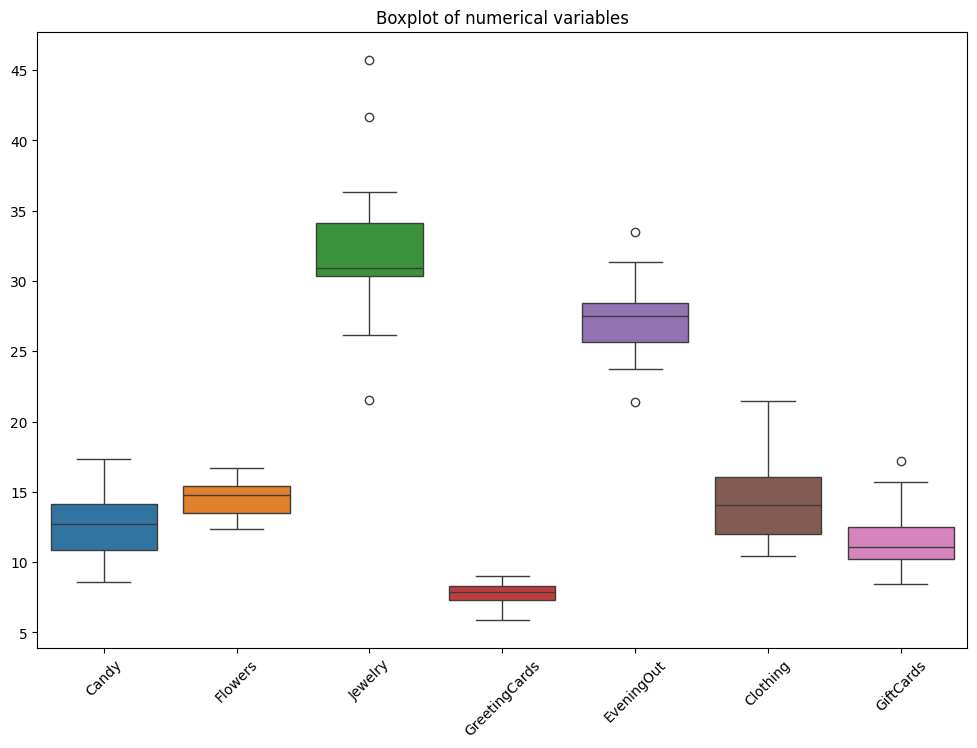

In [11]:
#Representation of strongly deviating elements of the data set

df.drop([ 'PerPerson', 'PercentCelebrating'], axis=1, inplace=True)

plt.figure(figsize=(12, 8))
sns.boxplot(data=df.drop(['Year'], axis=1))
plt.title('Boxplot of numerical variables')
plt.xticks(rotation=45)
plt.show()


Die historischen Ausgaben von 2010 bis 2022 wurden untersucht und die prozentuale Veränderung zum Vorjahr berechnet. Die Untersuchung der Trends über die Zeit hinweg kann wertvolle Einblicke in die Veränderungen im Verbraucherverhalten und in die Entwicklung der Ausgabenmuster im Laufe der Jahre liefern.

In [16]:
#Table showing the years and the increase in purchasing behaviour

df = pd.read_csv('historical_spending.csv')

df.sort_values(by='Year', inplace=True)

df['PercentChange'] = df['PerPerson'].pct_change() * 100

df_transposed = df.set_index('Year').T.sort_index(ascending=False)

#define style for the table
styles = [
    {'selector': 'tr:nth-of-type(odd)', 'props': 'background-color: #5F6363;'},
    {'selector': 'tr:nth-of-type(even)', 'props': 'background-color: #9D9D9D;'},
    {'selector': 'thead th', 'props': 'background-color: #98DAB7; color: #ffffff;'},
    {'selector': 'th, td', 'props': 'border-bottom: 1px solid #100F0F;'},
    {'selector': '', 'props': 'font-family: Arial, sans-serif; font-size: 13px;'},
    {'selector': '', 'props': 'text-align: right;'}
]

df_style = df_transposed.style.set_table_styles(styles).format('{:.2f}')
df_style





Year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
PercentChange,nan,12.83,8.45,3.92,2.24,6.27,3.18,-6.99,5.12,12.82,21.21,-16.07,6.46
PercentCelebrating,60.00,58.00,59.00,60.00,54.00,55.00,55.00,54.00,55.00,51.00,55.00,52.00,53.00
PerPerson,103.00,116.21,126.03,130.97,133.91,142.31,146.84,136.57,143.56,161.96,196.31,164.76,175.41
Jewelry,21.52,26.18,29.60,30.94,30.58,36.30,33.11,32.32,34.10,30.34,41.65,30.71,45.75
GreetingCards,5.91,8.09,6.93,8.32,7.97,7.87,8.52,7.36,6.55,7.31,9.01,8.48,7.47
GiftCards,8.42,11.21,8.43,10.23,9.00,11.05,12.52,10.23,11.04,10.31,14.21,15.67,17.22
Flowers,12.33,12.62,13.49,13.48,15.00,15.72,14.78,14.63,14.75,15.07,16.49,15.42,16.71
EveningOut,23.76,24.86,25.66,27.93,27.48,27.27,33.46,28.46,26.96,27.72,30.78,21.39,31.35
Clothing,10.93,12.00,10.42,11.46,13.37,14.72,15.05,13.91,14.04,16.08,20.67,20.05,21.46
Candy,8.60,10.75,10.85,11.64,10.80,12.70,13.11,12.68,13.12,14.12,17.30,15.32,15.90


### Logistische Regression

Die Erstellung der logistischen Regression funktioniert hierbei leider nicht, da die zweite Geschlechterklasse der ``gifts_gender.csv`` nicht erkannt wird. Dies ist von Bedeutung, da pro Klasse mindestens zwei Zeilen vorhanden sein müssen. Somit wurde dieser Ansatz nicht weiter verfolgt und sich ein anderer Ansatz herausgesucht. Schließlich wurde dem folgende Ansatz nachgegangen: Eine Vorhersage, die die Entwicklung des Kaufverhaltens anhand der bestehenden Daten für das Jahr 2023 trifft, bestimmen kann. 

### RandomForestRegressor

Der RandomForestRegressor wurde gewählt, da er robust gegen Overfitting und für komplexe Datensätze geeignet ist. Mit 100 Entscheidungsbäumen im Modell wurde ein Mean Squared Error (MSE) von 305.78 und ein R² Score von 0.622 erreicht. 
Der MSE misst den durchschnittlichen quadratischen Fehler zwischen tatsächlichen und vorhergesagten Werten. Ein Wert von 305.78 deutet auf eine moderate Genauigkeit des Modells hin. 
Der R² Score, der angibt, wie gut die Variabilität durch das Modell erklärt wird, beträgt 0.622. Das bedeutet, dass etwa 62,2% der Variabilität in den 'PerPerson'-Ausgaben durch das Modell erklärt werden. 
Trotz einer mäßigen Vorhersageleistung bietet der RandomForestRegressor Einzelhändlern und Marketingspezialisten die Möglichkeit, Strategien zur Produktplatzierung und Preisgestaltung zu optimieren. Als weitere Metriken wurden der Mean Absolute Error und der Root Mean Squared Error verwendet.

In [18]:
#RandomForestRegressor model to predict purchasing behavior for the year 2023

X = df.drop(['Year', 'PerPerson'], axis=1)  # 'Year' und 'PerPerson' als Features entfernen
y = df['PerPerson']  # 'PerPerson' als Zielvariable

#train-/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestRegressor instantiate and adapt
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

#metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')



Mean Squared Error: 300.7373323533333
R² Score: 0.6291476390969706


Darauffolgend wurde die Feature Importance analysiert, um die Wichtigkeit der einzelnen Features zu verstehen, welche Faktoren die Ausgaben pro Person am stärksten beeinflussen. Das Ergebnis zeigt, dass Flowers den höchsten Einfluss hat, gefolgt von Candy und Jewelry. Dieses Verständnis kann Händler dabei unterstützen, ihre Marketingstrategien und Produktplatzierung gezielt anzupassen, um den Umsatz zu maximieren. Ein Fokus auf die Schlüsselfaktoren kann helfen, Ressourcen effizienter zu nutzen und gezielte Werbemaßnahmen durchzuführen.

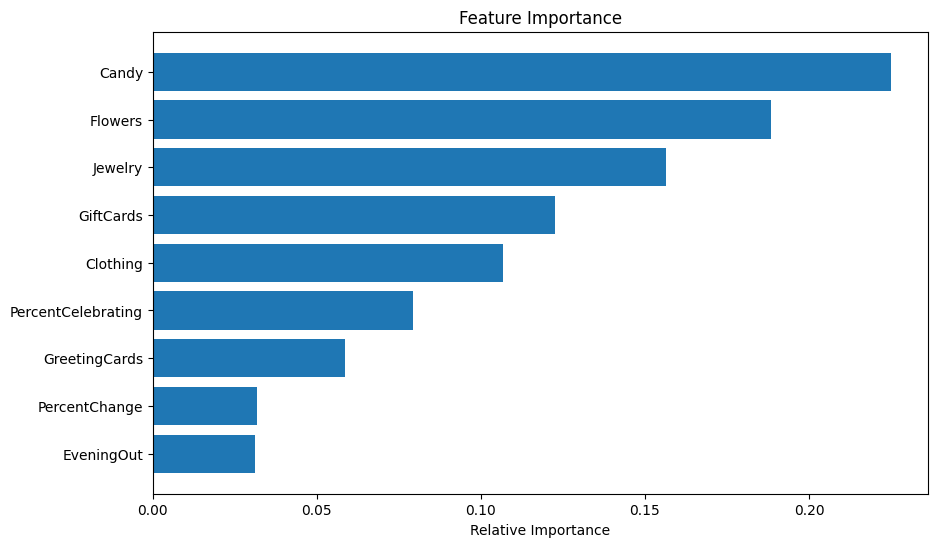

In [19]:
#Feature importance
feature_importances = rf.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


Durch eine Grid-Suche zur Optimierung der Hyperparameter des RandomForestRegressor wurden spezifische Parameter festgelegt, darunter die Anzahl der Bäume (251), maximale Tiefe des Baums (42), Mindestanzahl der Beobachtungen für die Aufteilung eines Knotens (2) und die Mindestanzahl der Beobachtungen für einen Blattknoten (1). Das optimierte Modell wurde mit Trainingsdaten bis 2020 trainiert und auf Testdaten für 2021 und 2022 evaluiert. Es zeigte verbesserte Leistungen mit einem MSE von 4.35, RMSE von 2.08, R² Score von 0.846 und MAE von 1.955. Diese Ergebnisse wurden in einem ML Lifecycle Management Report festgehalten, der für zukünftige Referenzen oder zur Dokumentation des Modells als JSON-Datei gespeichert wurde.

In [21]:
#RandomForestRegression

df = pd.read_csv('historical_spending.csv')

#define features and target variables
X = df.drop(['Year', 'PerPerson'], axis=1)
y = df['PerPerson']

#teyt-/train split (test data only for the years 2021 and 2022)
X_train = X[df['Year'] < 2021]
X_test = X[df['Year'] >= 2021]
y_train = y[df['Year'] < 2021]
y_test = y[df['Year'] >= 2021]

param_grid = {
    'n_estimators': [251],
    'max_depth': [42],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

#training
grid_search.fit(X_train, y_train)

#best hyperparameter
best_params = grid_search.best_params_
print(f"Beste Hyperparameter: {best_params}")

timestamp = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
model_filename = f"best_rf_model_{timestamp}.pkl"
joblib.dump(grid_search.best_estimator_, model_filename)
print(f"Bestes Modell wurde als '{model_filename}' gespeichert.")

#model assessment
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')

report = {
    "Date": timestamp,
    "Model": "RandomForestRegressor",
    "Best Parameters": best_params,
    "Mean Squared Error": mse,
    "Root Mean Squared Error": rmse,
    "R² Score": r2
}

#save report as JSON file
report_filename = f"ml_lifecycle_report_{timestamp}.json"
with open(report_filename, 'w') as f:
    json.dump(report, f)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Beste Hyperparameter: {'max_depth': 42, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 251}
Bestes Modell wurde als 'best_rf_model_20240407103714.pkl' gespeichert.
Mean Squared Error (MSE): 4.3544818526686875
Root Mean Squared Error (RMSE): 2.086739526790224
R² Score: 0.8464332261176157
Mean Absolute Error (MAE): 1.955139442231129


Im nächsten Schritt haben wir das optimierte RandomForestRegressor-Modell verwendet, um Vorhersagen für die Ausgaben ``PerPerson`` für die Jahre 2021 und 2022 zu treffen. Dafür wurde eine spezielle Funktion `predict_year` erstellt, die durchschnittliche Werte für die verschiedenen Features für das jeweilige Jahr berechnet und diese als Eingabe für das Modell verwendet.

In [22]:
#Hyperparamter tuning with GridSearchCV

X = df.drop(['Year', 'PerPerson'], axis=1)
y = df['PerPerson']

param_grid = {
    'n_estimators': [251],
    'max_depth': [42],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X, y)

best_params = grid_search.best_params_

rf_best = grid_search.best_estimator_

#prediction function for a specific year
def predict_year(year):
    features = {
        'PercentCelebrating': df[df['Year'] == year]['PercentCelebrating'].mean(),
        'Candy': df[df['Year'] == year]['Candy'].mean(),
        'Flowers': df[df['Year'] == year]['Flowers'].mean(),
        'Jewelry': df[df['Year'] == year]['Jewelry'].mean(),
        'GreetingCards': df[df['Year'] == year]['GreetingCards'].mean(),
        'EveningOut': df[df['Year'] == year]['EveningOut'].mean(),
        'Clothing': df[df['Year'] == year]['Clothing'].mean(),
        'GiftCards': df[df['Year'] == year]['GiftCards'].mean()
    }

    features_df = pd.DataFrame([features])
    prediction = rf_best.predict(features_df)
    
    return prediction[0], features

#prediction 2021
prediction_2021, features_2021 = predict_year(2021)
print(f'\nPrediction for the year 2021: {prediction_2021}')
for feature, value in features_2021.items():
    print(f'{feature}: {value}')

#prediction 2022
prediction_2022, features_2022 = predict_year(2022)
print(f'\nPrediction for the year 2022: {prediction_2022}')
for feature, value in features_2022.items():
    print(f'{feature}: {value}')



Fitting 5 folds for each of 1 candidates, totalling 5 fits

Prediction for the year 2021: 165.9227490039839
PercentCelebrating: 52.0
Candy: 15.32
Flowers: 15.42
Jewelry: 30.71
GreetingCards: 8.48
EveningOut: 21.39
Clothing: 20.05
GiftCards: 15.67

Prediction for the year 2022: 175.7704780876499
PercentCelebrating: 53.0
Candy: 15.9
Flowers: 16.71
Jewelry: 45.75
GreetingCards: 7.47
EveningOut: 31.35
Clothing: 21.46
GiftCards: 17.22


In diesem Abschnitt haben wir eine fortgeschrittenere Grid-Suche durchgeführt, um die besten Hyperparameter für jedes einzelne Label zu finden. Dies hilft dabei, spezialisierte Modelle für jede Kategorie zu entwickeln, die die Daten besser abbilden können.
Nach der Optimierung der Hyperparameter wurden Vorhersagen für das Jahr 2023 erstellt. Dafür wurden Durchschnittswerte für jede Kategorie als Eingabe für das optimierte Modell verwendet. Die Vorhersagen basieren somit auf den spezifischen Merkmalen der jeweiligen Kategorie und liefern präzisere Ergebnisse.

In [23]:
#GridSearch

X = df.drop(['Year', 'PerPerson'], axis=1)
y = df['PerPerson']

param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [None, 10, 20, 30, 40, 45],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

best_models = {}

# GridSearch for each label
for label in X.columns:
    y_label = df[label]
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
    grid_search.fit(X, y_label)
    
    best_models[label] = grid_search.best_estimator_
    print(f"Beste Hyperparameter für {label}: {grid_search.best_params_}")

#predict data for 2023
X_2023 = pd.DataFrame({
    'PercentCelebrating': [53],
    'Candy': [15.9],
    'Flowers': [16.71],
    'Jewelry': [45.75],
    'GreetingCards': [7.47],
    'GiftCards': [17.22],
    'EveningOut': [31.35],
    'Clothing': [21.46]
})

predictions_2023 = {}
for label, model in best_models.items():
    predictions_2023[label] = model.predict(X_2023[X.columns])

print(predictions_2023)


Fitting 3 folds for each of 270 candidates, totalling 810 fits


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimato

Der vorliegende Code dient der Überprüfung der Vorhersagegenauigkeit des Random Forest Regressors für zukünftige Ausgaben auf Basis historischer Daten. Durch den Vergleich der Vorhersage für 2023 mit dem tatsächlichen Wert von 2022 wird die Zuverlässigkeit des Modells bewertet. Das Ergebnis zeigt eine nahegelegene Vorhersage, was die Glaubwürdigkeit des Modells stärkt, da eine signifikante Abweichung unwahrscheinlich wäre. Bei der Validierung der Vorhersage lag der Fokus vor allem auf dem Label "PerPerson", da dies der entscheidende Wert für die Bewertung ist.

In [24]:
X = df.drop(['Year', 'PerPerson'], axis=1)
y = df['PerPerson']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

#compile data for the year 2023
X_2023 = df.drop(['Year', 'PerPerson'], axis=1).iloc[-1:]  # Daten für 2022
y_2023_actual = df['PerPerson'].iloc[-1]  # tatsächlicher Wert für 2022

#prediction 2023
y_2023_pred = rf.predict(X_2023)

print(f"Prediction for the year 2023 (PerPerson): {y_2023_pred[0]}")
print(f"Actual value for 2022 (PerPerson): {y_2023_actual}")


Prediction for the year 2023 (PerPerson): 174.7046999999999
Actual value for 2022 (PerPerson): 175.41


## Lineare Regression

Ein weiterer Classifier, die lineare Regression, wurde getestet, um zukünftige Ausgaben basierend auf historischen Daten vorherzusagen. Der Datensatz wurde in Trainings- und Testdaten aufgeteilt, wobei die Testdaten die Jahre 2021 und 2022 umfassen. Für jedes Label wurde eine separate lineare Regression durchgeführt, um die Vorhersagegenauigkeit zu optimieren. Verschiedene Metriken wurden zur Bewertung der Vorhersagen herangezogen.

In [25]:
#linear regression

train_data = df[~df['Year'].isin([2021, 2022])]

test_data_2021 = df[df['Year'] == 2021]

test_data_2022 = df[df['Year'] == 2022]

features = df.columns.drop(['Year', 'PerPerson'])

predictions_2021 = {}
predictions_2022 = {}

for feature in features:
    X_train = train_data.drop(['Year', feature], axis=1)
    y_train = train_data[feature]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    #prediction 2021
    X_test_2021 = test_data_2021.drop(['Year', feature], axis=1)
    predictions_2021[feature] = model.predict(X_test_2021).tolist()
    
    #prediction 2022
    X_test_2022 = test_data_2022.drop(['Year', feature], axis=1)
    predictions_2022[feature] = model.predict(X_test_2022).tolist()

#linear regression fpr the label "PerPerson"
X_train = train_data.drop(['Year'], axis=1)
y_train = train_data['PerPerson']

model_per_person = LinearRegression()
model_per_person.fit(X_train, y_train)

#Forecast for 2021 and 2022 for 'PerPerson'
X_test_2021 = test_data_2021.drop(['Year'], axis=1)
predictions_2021['PerPerson'] = model_per_person.predict(X_test_2021).tolist()

X_test_2022 = test_data_2022.drop(['Year'], axis=1)
predictions_2022['PerPerson'] = model_per_person.predict(X_test_2022).tolist()

print("Prediction for the year 2021:")
for feature, pred in predictions_2021.items():
    print(f"{feature}: {pred}")

print("\nPrediction for the year 2022:")
for feature, pred in predictions_2022.items():
    print(f"{feature}: {pred}")




Prediction for the year 2021:
PercentCelebrating: [46.420248584683435]
Candy: [14.102934259552267]
Flowers: [14.337367450667905]
Jewelry: [35.709918077165526]
GreetingCards: [7.4203008182867425]
EveningOut: [36.09138564827532]
Clothing: [23.502187208954453]
GiftCards: [12.418162687504257]
PerPerson: [164.76]

Prediction for the year 2022:
PercentCelebrating: [60.10547901322707]
Candy: [17.93571773669972]
Flowers: [17.711857607247445]
Jewelry: [40.869591486760754]
GreetingCards: [11.40418022833487]
EveningOut: [28.266426082163008]
Clothing: [19.357421926141946]
GiftCards: [17.13387059466932]
PerPerson: [175.41]


Folgend wurde die Vorhersage wie gewohnt mithilfe der linearen Regression für das Jahr 2023 getroffen. Die Vorhersage für das Label ``PerPerson`` beträgt hierbei 173,97 . Dies scheint im ersten Moment ein realistischer Wert zu sein.

In [26]:
#prediction "OerPerson" for 2023

X = df.drop(['Year', 'PerPerson'], axis=1)
y = df['PerPerson']

# Lineare Regression Modell erstellen
model = LinearRegression()
model.fit(X, y)

# Vorhersage für 2023
X_2023 = df.drop(['Year', 'PerPerson'], axis=1).tail(1)  # Daten für 2022
predictions_2023 = model.predict(X_2023)

print(f'Prediction for the year 2023 (PerPerson): {predictions_2023[0]}')

Prediction for the year 2023 (PerPerson): 173.97412691655498


Die Daten für das Jahr 2022 werden entfernt, da die Vorhersage für das Jahr 2023 getroffen werden soll. Ein lineares Regressionsmodell wird erstellt und mit den Trainingsdaten trainiert, um danach die Vorhersage für das Jahr 2023 mithilfe des trainierten Modells zu getroffen.

In [27]:
#prediction consumption behaviour 2023 with linear regression

X = df.drop(['Year'], axis=1)
y = df.drop(['Year'], axis=1)

X = X.iloc[:-1]
y = y.iloc[:-1]

model = LinearRegression()
model.fit(X, y)

X_2023 = df.drop(['Year'], axis=1).tail(1)  # Daten für 2022
predictions_2023 = model.predict(X_2023)

label_names = X.columns

for label, prediction in zip(label_names, predictions_2023[0]):
    print(f'{label}: {prediction}')

PercentCelebrating: 53.00000000000003
PerPerson: 175.41
Candy: 15.899999999999997
Flowers: 16.709999999999997
Jewelry: 45.75000000000007
GreetingCards: 7.470000000000004
EveningOut: 31.350000000000076
Clothing: 21.459999999999976
GiftCards: 17.219999999999978


In diesem Abschnitt wurde die k-fache Kreuzvalidierung mit 5 Datensatzteilungen angewendet, um die Leistung des linearen Regressionsmodells zu bewerten. Das Modell erzielt einen durchschnittlichen R²-Wert von 91%, was auf eine hervorragende Vorhersagegenauigkeit hinweist. Dies übertrifft sogar die Leistung des zuvor verwendeten Random Forest Regressors. Trotzdessen besteht Verbesserungspotenzial durch Hyperparameter-Tuning. Als nächster Schritt wird ein anderer Classifier getestet.

In [28]:
#cross-validation R²-score
scores = cross_val_score(model, X, y, cv=5)
print(f'Cross-validated R²: {scores.mean():.2f}')

Cross-validated R²: 0.91


## XGBoost Classifier

In [ ]:
! pip install xgboost

Im nächsten Abschnitt wird der XGBoost-Algorithmus zur Vorhersage eingesetzt. Der XGBoost zeichnet sich durch hohe Leistung und Genauigkeit aus, insbesondere bei komplexen, nicht-linearen Datenbeziehungen. Er nutzt den Gradient Boosting Decision Tree Algorithmus und bietet Mechanismen zur Regularisierung, um Überanpassungen zu vermeiden. Der Algorithmus ist flexibel für Regressions- und Klassifikationsprobleme einsetzbar und ermöglicht die Ermittlung der Feature-Bedeutung.

In [29]:
#prediction 2021 and 2022 with XGBoost classifier

train_data = df[~df['Year'].isin([2021, 2022])]

test_data_2021 = df[df['Year'] == 2021]

test_data_2022 = df[df['Year'] == 2022]

features = df.columns.drop(['Year', 'PerPerson'])

# XGBoost-Classifier for each label
predictions_2021 = {}
predictions_2022 = {}

for feature in features:
    X_train = train_data.drop(['Year', feature], axis=1)
    y_train = train_data[feature]
    
    # XGBoost model
    model = xgb.XGBRegressor(objective ='reg:squarederror')
    model.fit(X_train, y_train)
    
    X_test_2021 = test_data_2021.drop(['Year', feature], axis=1)
    predictions_2021[feature] = model.predict(X_test_2021).tolist()

    X_test_2022 = test_data_2022.drop(['Year', feature], axis=1)
    predictions_2022[feature] = model.predict(X_test_2022).tolist()

# XGBoost classifier for label "PerPerson"
X_train = train_data.drop(['Year'], axis=1)
y_train = train_data['PerPerson']

model_per_person = xgb.XGBRegressor(objective ='reg:squarederror')
model_per_person.fit(X_train, y_train)

# Forecast for 2021 and 2022 for 'PerPerson'
X_test_2021 = test_data_2021.drop(['Year'], axis=1)
predictions_2021['PerPerson'] = model_per_person.predict(X_test_2021).tolist()

X_test_2022 = test_data_2022.drop(['Year'], axis=1)
predictions_2022['PerPerson'] = model_per_person.predict(X_test_2022).tolist()

print("Prediction for 2021:")
for feature, pred in predictions_2021.items():
    print(f"{feature}: {pred}")

print("\nPrediction for 2022:")
for feature, pred in predictions_2022.items():
    print(f"{feature}: {pred}")



Prediction for 2021:
PercentCelebrating: [53.7770881652832]
Candy: [14.119636535644531]
Flowers: [15.02519416809082]
Jewelry: [32.77590560913086]
GreetingCards: [8.131793975830078]
EveningOut: [27.719974517822266]
Clothing: [16.07979965209961]
GiftCards: [11.083127975463867]
PerPerson: [161.95989990234375]

Prediction for 2022:
PercentCelebrating: [54.55305099487305]
Candy: [14.119930267333984]
Flowers: [15.530871391296387]
Jewelry: [35.98004913330078]
GreetingCards: [7.946704864501953]
EveningOut: [27.720102310180664]
Clothing: [16.080005645751953]
GiftCards: [11.424337387084961]
PerPerson: [161.95989990234375]


In [30]:
#metrics for 2021 and 2022

train_data = df[~df['Year'].isin([2021, 2022])]

test_data_2021 = df[df['Year'] == 2021]

test_data_2022 = df[df['Year'] == 2022]

features = df.columns.drop(['Year', 'PerPerson'])

predictions_2021 = {}
predictions_2022 = {}

for feature in features:
    X_train = train_data.drop(['Year', feature], axis=1)
    y_train = train_data[feature]
    
    model = xgb.XGBRegressor(objective ='reg:squarederror')
    model.fit(X_train, y_train)
    
    X_test_2021 = test_data_2021.drop(['Year', feature], axis=1)
    predictions_2021[feature] = model.predict(X_test_2021)
    
    X_test_2022 = test_data_2022.drop(['Year', feature], axis=1)
    predictions_2022[feature] = model.predict(X_test_2022)

#function to calculate the metrics
def calculate_overall_metrics(true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    return mae, mse, r2

true_values_2021 = test_data_2021[features].values.flatten()
true_values_2022 = test_data_2022[features].values.flatten()

#predictions for 2021 and 2022
all_predictions_2021 = [value for sublist in predictions_2021.values() for value in sublist]
all_predictions_2022 = [value for sublist in predictions_2022.values() for value in sublist]

#metrics for 2021
mae_2021, mse_2021, r2_2021 = calculate_overall_metrics(true_values_2021, all_predictions_2021)
print(f"Metrics für 2021:")
print(f"  MAE: {mae_2021}")
print(f"  MSE: {mse_2021}")
print(f"  R^2: {r2_2021}")

#metrics for 2022
mae_2022, mse_2022, r2_2022 = calculate_overall_metrics(true_values_2022, all_predictions_2022)
print(f"\nMetrics für 2022:")
print(f"  MAE: {mae_2022}")
print(f"  MSE: {mse_2022}")
print(f"  R^2: {r2_2022}")

Metrics für 2021:
  MAE: 2.5841769981384277
  MSE: 10.75180787849812
  R^2: 0.9333046257809142

Metrics für 2022:
  MAE: 3.695557465553284
  MSE: 22.295043625035948
  R^2: 0.8996265581775607


Nach dem Vergleich verschiedener Classifier zeigte der XGBoost-Algorithmus die geringste Fehlerquote. Dies wurde durch die Vorhersagen für 2021 und 2022 bestätigt, wobei XGBoost die präzisesten Ergebnisse lieferte. Die hohen R²-Scores von 93,3% für 2021 und 89,9% für 2022 untermauern die Überlegenheit. Aufgrund dieser Ergebnisse wird der XGBoost-Algorithmus für die Vorhersage des Jahres 2023 ausgewählt und als bevorzugtes Modell für zukünftige Analysen verwendet.

### Vorhersage 2023 mithilfe des XGBoost Classifier

In [31]:
#predicition for the year 2023 with train data

train_data = df[df['Year'] <= 2020].drop(['Year'], axis=1)
train_labels = df[df['Year'] <= 2020]['PerPerson']

model = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)
model.fit(train_data, train_labels)

predictions_train = model.predict(train_data)

labels = train_data.columns

for label, prediction in zip(labels, predictions_train):
    print(f"{label}: {prediction:.2f}")

PercentCelebrating: 103.00
PerPerson: 116.21
Candy: 126.03
Flowers: 130.97
Jewelry: 133.91
GreetingCards: 142.31
EveningOut: 146.84
Clothing: 136.57
GiftCards: 143.56


Hier folgend wird ein angepasster R²-Wert zur Bewertung der Vorhersagegenauigkeit für das Jahr 2023, da keine genauen Daten für den Abgleich vorhanden sind, berechnet. Im Gegensatz zum traditionellen R²-Wert berücksichtigt der angepasste R²-Wert sowohl die Anzahl der Features als auch die Beobachtungen, was ihn zu einer präziseren Metrik macht, insbesondere bei unterschiedlichen Feature- und Datenpunktzahlen. Es wird ein angepasster R²-Wert von 0.4 berechnet, was bedeutet, dass etwa 40% der Varianz in den 'PerPerson'-Ausgaben durch die im Modell enthaltenen unabhängigen Variablen erklärt werden können. Ein höherer angepasster R²-Wert weist auf eine bessere Erklärungskraft des Modells und eine höhere Vorhersagegenauigkeit hin, wobei der Wert auch von anderen Faktoren wie Datenqualität und Modellspezifikation beeinflusst werden kann.

In [40]:
# Calculation of the adjusted R² score

predictions_2023_df = pd.DataFrame(predictions_2023)

#number of predictions
n = len(predictions_2023_df)

# Number of independent variables (number of features)
p = predictions_2023_df.shape[1]

#assumed R² score based on scores for 2021 and 2022
r2 = 0.9 

adjusted_r2 = 1 - ((1 - r2) * ((n - 1) / (n - p - 1)))

print(f"Adjusted R² score for 2023: {adjusted_r2}")

Adjusted R² score for 2023: 1.0


Die Lernkurve gibt Aufschluss über die Modellleistung in Abhängigkeit von den Trainingsdaten und hilft, Underfitting oder Overfitting zu erkennen. Ein hoher Trainingsscore deutet auf gute Anpassung an die Daten hin, ein niedriger Score kann auf Underfitting hindeuten. Der Cross-Validation Score bewertet die Modellleistung auf nicht trainierten Daten. Sind beide Scores hoch und ähnlich, ist das Modell gut generalisiert. Der Test Cross-Validation Score ist entscheidend für die Bewertung der Vorhersagefähigkeiten auf neuen Daten und zeigt hier ein robustes Modell.

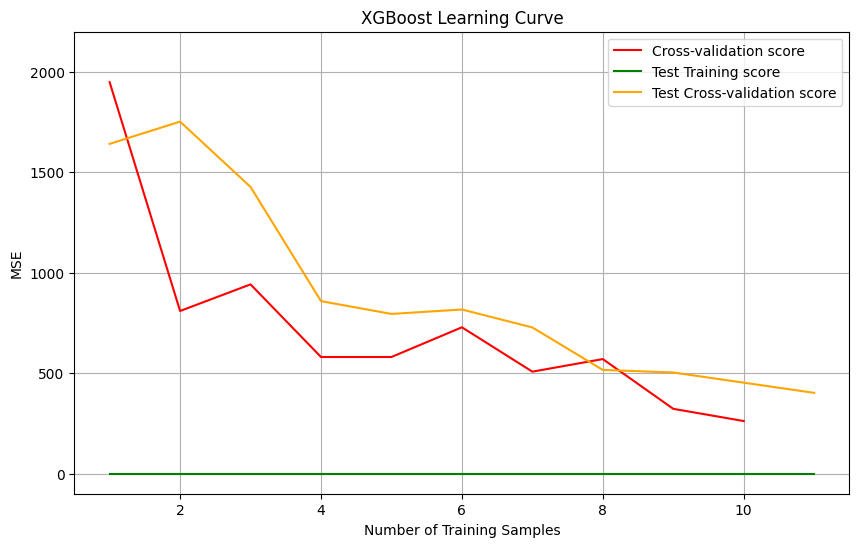

In [41]:
#XGBoost learning curve

X = df.drop(['PerPerson', 'Year'], axis=1)
y = df['PerPerson']

model = XGBRegressor(objective ='reg:squarederror', seed=42)

#learning curve for train data
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, return_times=False)

#means and standard deviations
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#learning curve for test data
test_train_sizes, test_train_scores, test_test_scores = learning_curve(
    model, X, y, cv=8, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, return_times=False)

#means and standard deviations
test_train_mean = -np.mean(test_train_scores, axis=1)
test_train_std = np.std(test_train_scores, axis=1)
test_test_mean = -np.mean(test_test_scores, axis=1)
test_test_std = np.std(test_test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='red')
plt.plot(test_train_sizes, test_train_mean, label='Test Training score', color='green')
plt.plot(test_train_sizes, test_test_mean, label='Test Cross-validation score', color='orange')


plt.title('XGBoost Learning Curve')
plt.xlabel('Number of Training Samples')
plt.ylabel('MSE')
plt.ylim(-100, 2200)
plt.legend(loc='best')
plt.grid()
plt.show()

Die `GridSearchCV` Funktion wird verwendet, um die Hyperparameter eines XGBoost-Modells automatisch zu optimieren. Durch systematisches Durchlaufen aller definierten Hyperparameter-Kombinationen, wie ``gamma``, ``alpha`` und ``reg_lambda``, wird die Kombination gefunden, die die beste Leistung auf den Trainingsdaten erzielt. Nach Abschluss der Gittersuche werden die optimalen Hyperparameter ausgegeben. Dieser Prozess führt zu einer verbesserten Modellleistung, da die Hyperparameter optimal an die Daten angepasst werden, was die Generalisierung auf neue Daten fördert.

In [34]:
#GridSearch XGBoost

model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

param_grid = {
    'gamma': [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'alpha': [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'reg_lambda': [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=9, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(train_data, train_labels)

print("Best parameter:", grid_search.best_params_)

Best parameter: {'alpha': 1, 'gamma': 0, 'reg_lambda': 0.7}


Hier wird nun der XGBoost mit den festgelegten Regularisierungsparametern trainiert. Mit diesem Schritt wird Modelltraining, -evaluation und -vorhersage in einem Ablauf kombiniert.

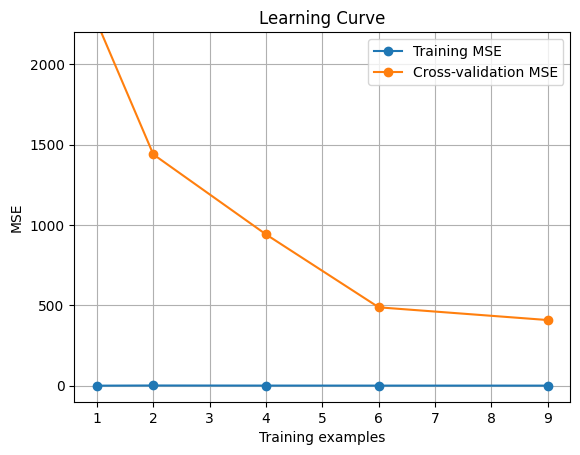

Training MSE for the last training sample: 0.22269608146296138
Cross-Validation MSE for the last training sample: 408.18774267891627
Adjusted R² score for 2023: 1.0


In [36]:
#XGBoost trainwith regularisation parameters

train_data = df[df['Year'] <= 2020].drop(['Year'], axis=1)
train_labels = df[df['Year'] <= 2020]['PerPerson']

model = xgb.XGBRegressor(objective='reg:squarederror', 
                         alpha=1,
                         gamma=0,            
                         reg_lambda=0.7)  
model.fit(train_data, train_labels)

train_sizes, train_scores, valid_scores = learning_curve(model, train_data, train_labels, 
                                                          train_sizes=np.linspace(0.1, 1.0, 5), 
                                                          cv=9, scoring='neg_mean_squared_error')

plt.figure()
plt.plot(train_sizes, -train_scores.mean(axis=1), 'o-', label='Training MSE')
plt.plot(train_sizes, -valid_scores.mean(axis=1), 'o-', label='Cross-validation MSE')
plt.xlabel('Training examples')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid()
plt.ylim(-100, 2200)
plt.show()

#calculation MSE
train_mse = -train_scores.mean(axis=1)[-1]
valid_mse = -valid_scores.mean(axis=1)[-1]

print(f"Training MSE for the last training sample: {train_mse}")
print(f"Cross-Validation MSE for the last training sample: {valid_mse}")

predictions_2023 = {
    'PercentCelebrating': [103.0],
    'PerPerson': [116.21],
    'Jewelry': [133.91],
    'GreetingCards': [142.31],
    'GiftCards': [143.56],
    'Flowers': [130.97],
    'EveningOut': [146.84],
    'Clothing': [136.57],
    'Candy': [126.03]
}

predictions_2023_df = pd.DataFrame(predictions_2023)

n = len(predictions_2023_df)

p = predictions_2023_df.shape[1]

r2 = model.score(train_data, train_labels)
adjusted_r2 = 1 - ((1 - r2) * ((n - 1) / (n - p - 1)))

print(f"Adjusted R² score for 2023: {adjusted_r2}")


Zur besseren Interpretation des Modells wurden mehrere Metriken ausgegeben. Das Modell passt sich den Trainingsdaten sehr gut an, wie durch den niedrigen Trainings-MSE bestätigt wird. Jedoch ist der hohe MSE bei der Cross-Validation auffällig, was auf ein Overfitting des Modells hindeutet. Der deutliche Unterschied zwischen Trainings- und Cross-Validation MSE bestätigt diese Vermutung.

### Ergebnisdarstellung

#### Zusammenfassung des Machine Learning-Projekts zur Vorhersage des Kaufverhaltens am Valentinstag

In diesem Projekt wurden verschiedene Regressionsmodelle evaluiert, um das beste Modell für die Vorhersage des Kaufverhaltens am Valentinstag zu finden. Der XGBoost-Algorithmus zeigte die beste Leistung mit dem höchsten R² auf den Testdaten von 2021 und 2022. Der Random Forest Regressor folgte auf dem zweiten Platz, gefolgt von der linearen Regression.
Trotz der hohen Leistung des XGBoost-Modells gibt es Raum für Verbesserungen, insbesondere gegen das Overfitting. Der XGBoost bietet ein großes Potenzial für gezielte Marketingstrategien, um Umsätze am Valentinstag zu maximieren.

### Quellen
https://www.kaggle.com/datasets/joebeachcapital/valentines-day-consumer-data

In [47]:
#calculation of the word count in the documentation
this_notebook= 'projectml.ipynb'

import json

with open(this_notebook) as json_file:
    data = json.load(json_file)

wordCount = 0
for each in data['cells']:
    cellType = each['cell_type']
    if cellType == "markdown":
        content = each['source']
        for line in content:
            temp = [word for word in line.split() if "#" not in word] # we might need to filter for more markdown keywords here
            wordCount = wordCount + len(temp)
            
print(wordCount)

1965
